In this example we turn to a condensed matter system, namely, liquid sodium at 375 K and 1 bar. Interatomic interactions are described with an embedded atom model (EAM) potential. Since we are around the melting point of Na, we wish to study its phase equilibrium. To do this, we must induce crytallization, followed by again melting (and so on). We'll again use well-tempered metadynamics ($\gamma = 30$) as enhanced sampling method, and a reweighting strategy to reconstruct the FES.

The first simulation, which can be found in the folder <code>global</code>, uses a *global* CV for biasing. [This CV](https://doi.org/10.1103/PhysRevLett.119.015701), which we'll denote $s_p$, is a surrogate for the entropy in the system, and is based on an expression for the pair entropy. Because phase transitions entail an entropy change, $s_p$ might be a nicely generic choice to accelerate any such process.

Let's first plot the histogram $H(s_p)$, obtained after a 100 ns sampling run:

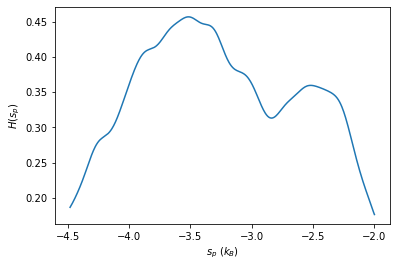

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sp = np.loadtxt('global/histosp', skiprows=10, usecols=0)
H_sp = np.loadtxt('global/histosp', skiprows=10, usecols=1)
plt.plot(sp,H_sp)
plt.xlabel("$s_p$ ($k_B$)")
plt.ylabel("$H(s_p)$")
plt.show()

Looks good, no? The bias has nicely flattened the histogram as it was supposed to do. This means that the system should be able to move back and forth rapidly. Let's take a look at the trajectory $s_p(t)$

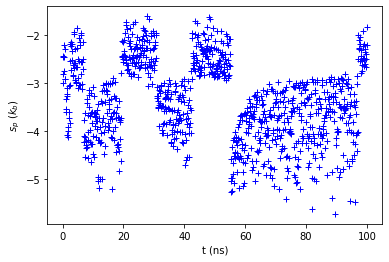

In [2]:
t = np.loadtxt('global/colvar', skiprows=1, usecols=0)
sp_t = np.loadtxt('global/colvar', skiprows=1, usecols=2)
q6_t = np.loadtxt('global/colvar', skiprows=1, usecols=3)
plt.plot(t,sp_t,'b+')
plt.xlabel("t (ns)")
plt.ylabel("$s_p$ ($k_b$)")
plt.show()

This is... not that great? With such a flat histogram, we wouldn't expect a single transition to take several ns!

We'll investigate this issue further by invoking an additional CV. This CV, $\overline{q}_6$, measures the local symmetry of individual atoms *and* their neighbors, averaged over all atoms. It therefore specifically probes the existence of crystallites. What does $H (\overline{q}_6)$ tell us?

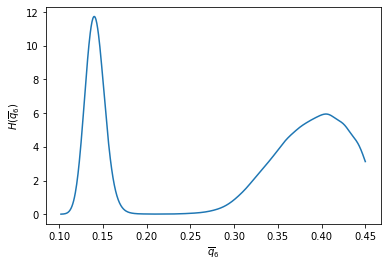

In [3]:
q6 = np.loadtxt('global/histoq6l', skiprows=10, usecols=0)
H_q6 = np.loadtxt('global/histoq6l', skiprows=10, usecols=1)
plt.plot(q6,H_q6)
plt.xlabel("$\overline{q}_6$")
plt.ylabel("$H(\overline{q}_6)$")
plt.show()

This histogram doesn't look that flattened at all!

It seems that $s_p$ cannot properly distinguish transition state configurations from metastable ones. Note also the overlapping regions in the $s_p(t)$ trajectory, whereas the $\overline{q}_6 (t)$ trajectory reveals the existence of poorly-sampled intermidiate regions.

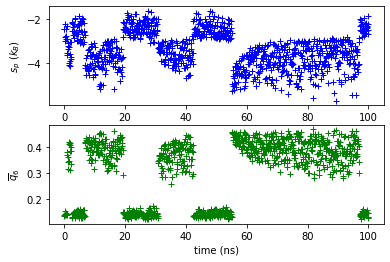

In [4]:
plt.subplot(2, 1, 1)
plt.plot(t,sp_t,'b+')
plt.ylabel("$s_p$ ($k_B$)")

plt.subplot(2, 1, 2)
plt.plot(t,q6_t,'g+')
plt.xlabel("time (ns)")
plt.ylabel("$\overline{q}_6$")

plt.show()

We also notice that the apparent barrier is higher on $G (\overline{q}_6)$ than on $G (s_p)$:

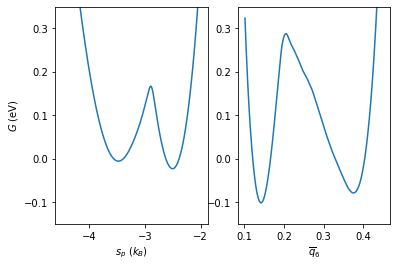

In [5]:
G_sp = np.loadtxt('global/fessp', skiprows=10, usecols=1)
G_q6 = np.loadtxt('global/fesq6l', skiprows=10, usecols=1)

plt.subplot(1, 2, 1)
plt.plot(sp,G_sp)
plt.xlabel("$s_p$ ($k_B$)")
plt.ylabel("$G$ (eV)")
plt.ylim([-0.15,0.35])

plt.subplot(1, 2, 2)
plt.plot(q6,G_q6)
plt.xlabel("$\overline{q}_6$")
plt.ylim([-0.15,0.35])

plt.show()

So $s_p$ is a worse *reaction coordinate* than $\overline{q}_6$. However, it is actually still a good *order parameter*, as an evaluation of the free energy of fusion $\Delta G_{l \rightarrow s}$ shows. Both FES projections are equivalent in this respect.

In [6]:
kT = 0.032315
Gs = np.exp(-G_sp[0:300]/kT)
Gl = np.exp(-G_sp[300:500]/kT)
DeltaF = -kT*np.log(np.sum(Gs)/np.sum(Gl))
print("Free energy of fusion (eV)")
print("Based on s_p: ", DeltaF)

# basins are reversed
Gs = np.exp(-G_q6[250:700]/kT)
Gl = np.exp(-G_q6[0:250]/kT)
DeltaF = -kT*np.log(np.sum(Gs)/np.sum(Gl))
print("Based on q6:  ", DeltaF)

Free energy of fusion (eV)
Based on s_p:  0.004077401126437429
Based on q6:   0.0039477364095342705


So, what happens if we bias $\overline{q}_6$ instead? Let's plot the trajectory $\overline{q}_6 (t)$ for such a simulation:

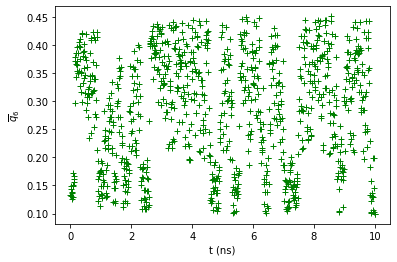

In [7]:
t_l = np.loadtxt('local/colvar', skiprows=1, usecols=0)
sp_t_l = np.loadtxt('local/colvar', skiprows=1, usecols=2)
q6_t_l = np.loadtxt('local/colvar', skiprows=1, usecols=3)
plt.plot(t_l,q6_t_l,'g+')
plt.xlabel("t (ns)")
plt.ylabel("$\overline{q}_6$")
plt.show()

That's more like it! We get much more transitions than previously, and we only need a **10 ns** run (compared to 100 ns with the global CV)! So, picking a good CV for biasing affects performance by orders of magnitude. Anyway, we can see that good biasing is all about flattening the *right* probability distribution:

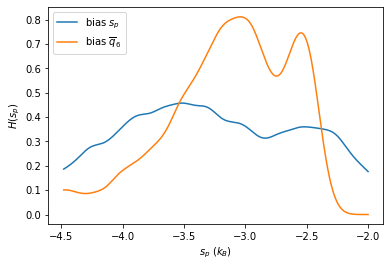

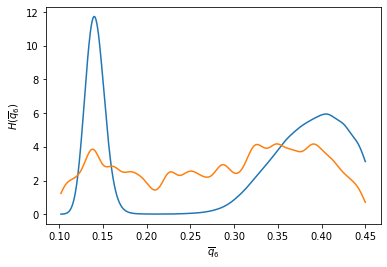

In [8]:
H_sp_l = np.loadtxt('local/histosp', skiprows=10, usecols=1)
H_q6_l = np.loadtxt('local/histoq6l', skiprows=10, usecols=1)

plt.plot(sp,H_sp,label = "bias $s_p$")
plt.plot(sp,H_sp_l,label = "bias $\overline{q}_6$")
plt.xlabel("$s_p$ ($k_B$)")
plt.ylabel("$H(s_p)$")
plt.legend()
plt.show()


plt.plot(q6,H_q6,label = "bias $s_p$")
plt.plot(q6,H_q6_l,label = "bias $\overline{q}_6$")
plt.xlabel("$\overline{q}_6$")
plt.ylabel("$H(\overline{q}_6)$")
plt.show()

If both sets of simulations have converged, both should yield an equivalent FES $G(\overline{q}_6)$. Do they?

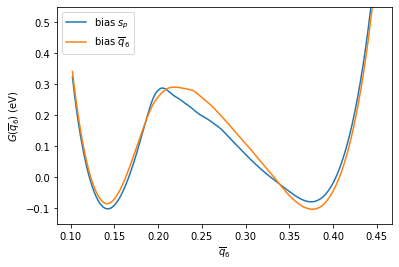

Free energy of fusion (eV)
Based on global biasing:  0.0039477364095342705
Based on local biasing:   -0.03455646699754474


In [9]:
G_q6_l = np.loadtxt('local/fesq6l', skiprows=10, usecols=1)

plt.plot(q6,G_q6,label = "bias $s_p$")
plt.plot(q6,G_q6_l,label = "bias $\overline{q}_6$")
plt.xlabel("$\overline{q}_6$")
plt.ylabel("$G(\overline{q}_6$) (eV)")
plt.ylim([-0.15,0.55])
plt.legend()
plt.show()

print("Free energy of fusion (eV)")
print("Based on global biasing: ", DeltaF)

# basins are reversed
Gs = np.exp(-G_q6_l[250:700]/kT)
Gl = np.exp(-G_q6_l[0:250]/kT)
DeltaF = -kT*np.log(np.sum(Gs)/np.sum(Gl))
print("Based on local biasing:  ", DeltaF)

**Further questions & exercises:**
1. According the coexistence simulations with the same potential, the melting point of Na is 366 K. Comment on the error bar on the FESes.
2. So... did we converge?
3. Why am I using $G$ instead for $F$ for the free energy?
4. Biasing $\overline{q}_6$ is much more efficient than biasing $s_p$, in the sense that it is a much better reaction coordinate. Take a look at the timing information in the (redacted) <code>out.lammps</code> files. What do you see? How would this information affect your CV choices? How does reweighting play into these decisions?